# BullDozer price prediction with time using regression

The first 4 steps of our framework are:
1. **Problem Definition:**
   * Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.
2. **Data:**
   * The data has been aquired from kaggle via https://www.kaggle.com/c/bluebook-for-bulldozers/data
   * There are 3 main datasets:
       1. Train.csv is the training set, which contains data through the end of 2011.
       2. Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the     majority of the competition. Your score on this set is used to create the public leaderboard.
       3. Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

3. **Evaluation:**
   * The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
  
4. **Features:**
   * The key fields are in train.csv are:

      * SalesID: the uniue identifier of the sale
      * MachineID: the unique identifier of a machine.  A machine can be sold multiple times
      * saleprice: what the machine sold for at auction (only provided in train.csv)
      * saledate: the date of the sale

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploring our data

In [3]:
df=pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


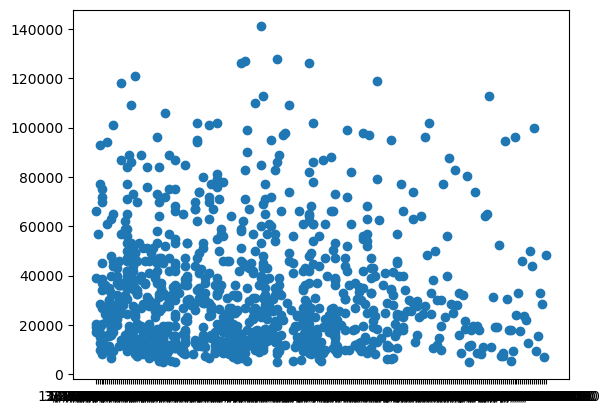

In [6]:
plt.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

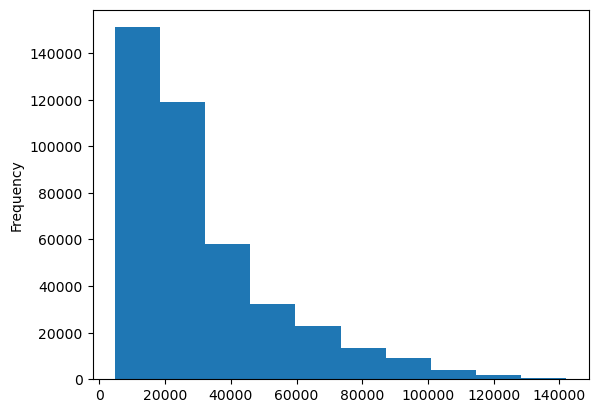

In [13]:
df.SalePrice.plot(kind="hist");

## Parsing the dates now

In [15]:
df=pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

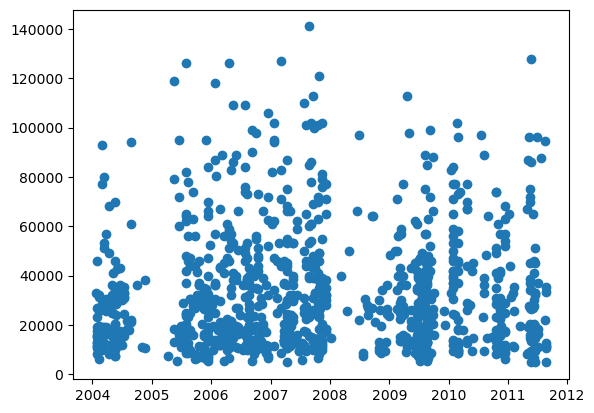

In [17]:
plt.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

## Sorting by saledate

In [18]:
df=df.sort_values(by='saledate',ascending=True)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


## Feature Engineering

Splitting saledate into different features (saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear)

In [19]:
#Creating temp copy of df to work on
df_tmp=df.copy()

In [24]:
df_tmp['saleYear']=df_tmp.saledate.dt.year
df_tmp['saleMonth']=df_tmp.saledate.dt.month
df_tmp['saleDay']=df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek']=df_tmp.saledate.dt.day_of_week
df_tmp['saleDayOfYear']=df_tmp.saledate.dt.day_of_year
df_tmp.drop('saledate',axis=1,inplace=True)

In [25]:
df_tmp.T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B,D6C,IT12,544,D5HII,12F,...,544H,317,S175,WA320,710VHP,D38E,2064,337G,12G,544H


## Turning data into numbers

In [26]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [36]:
#Identifying all the columns that have dtype as 'object'
for label,content in df_tmp.items():
    if pd.api.types.infer_dtype(content)=='string':
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [41]:
#Converting all those that have string dtype to catagorical dtype
for col in df_tmp.columns:
    if pd.api.types.infer_dtype(df_tmp[col])=='string':
        df_tmp[col]=df_tmp[col].astype('category').cat.as_ordered()

In [42]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

## Filling missing values

In [48]:
df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### 1. Numerical values

In [55]:
#Checking all features that are numerical and have missing values
for col in df_tmp.columns:
    if pd.api.types.is_numeric_dtype(df_tmp[col]):
        if df_tmp[col].isna().sum():
            print(col)

auctioneerID
MachineHoursCurrentMeter


In [67]:
#Filling missing values with median
for col in df_tmp.columns:
    if pd.api.types.is_numeric_dtype(df_tmp[col]):
        if df_tmp[col].isna().sum():
            df_tmp[col+"_is_missing"]=df_tmp[col].isna()
            df_tmp[col]=df_tmp[col].fillna(df_tmp[col].median())

In [68]:
df_tmp["auctioneerID_is_missing"].value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

### 2. Categorical values

In [72]:
#Checking for catagorical features with null values
for col in df_tmp.columns:
    if pd.api.types.is_categorical_dtype(df_tmp[col]):
        if df_tmp[col].isna().sum():
            print(col)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


C:\Users\saksh\AppData\Local\Temp\ipykernel_13244\2449166205.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_tmp[col]):


In [77]:
#Filling catagorical features with values
for col in df_tmp.columns:
    if pd.api.types.is_categorical_dtype(df_tmp[col]):
        df_tmp[col+"_is_missing"]=df[col].isnull()
        df_tmp[col]=df_tmp[col].cat.codes+1;

C:\Users\saksh\AppData\Local\Temp\ipykernel_13244\4237572327.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_tmp[col]):


In [83]:
df_tmp["UsageBand"].value_counts()

UsageBand
0    339028
3     35832
2     25311
1     12527
Name: count, dtype: int64

# Fitting a machine learning model

## Splitting data into training and validation sets

Note: According to the competition on kaggle, all the data from 2012 was to be in the validation set and all data before in the training sets

In [84]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [88]:
x_train,y_train=df_tmp[df_tmp.saleYear!=2012].drop('SalePrice',axis=1),df_tmp[df_tmp.saleYear!=2012].SalePrice

In [92]:
x_val,y_val=df_tmp[df_tmp.saleYear==2012].drop('SalePrice',axis=1),df_tmp[df_tmp.saleYear==2012].SalePrice

## Creating custom evaluation function - RMSLE 

According to the competition on kaggle, the evaluation metric used is Root mean squared log error RMSLE

In [202]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test,y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

def score(model):
    y_preds_train=model.predict(x_train)
    y_preds_val=model.predict(x_val)
    scores={"MAE Train set":mean_absolute_error(y_train,y_preds_train),
            "MAE valid set":mean_absolute_error(y_val,y_preds_val),
            "RMSLE train set": rmsle(y_train,y_preds_train),
            "RMSLE valid set": rmsle(y_val,y_preds_val),
            "R^2 Score train set":r2_score(y_train,y_preds_train),
            "R^2 Score valid set":r2_score(y_val,y_preds_val)}
    return scores

## Tuning and improving hyperparameters using RandomSearchCV (on only first 10000 rows)

In [98]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_grid={"n_estimators":np.arange(10,100,10),
         "max_depth":(None,3,5,10),
         "min_samples_leaf":np.arange(2,20,2),
         "min_samples_split":np.arange(1,20,2),
         "max_features":[0.5,1,"sqrt","auto"],
         "max_samples":[10000]}

rf_model=RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                            param_distributions=rf_grid,
                            n_iter=100,
                            cv=5,
                            verbose=3)
rf_model.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=5, max_features=sqrt, max_samples=10000, min_samples_leaf=12, min_samples_split=15, n_estimators=50;, score=0.311 total time=   1.9s
[CV 2/5] END max_depth=5, max_features=sqrt, max_samples=10000, min_samples_leaf=12, min_samples_split=15, n_estimators=50;, score=0.471 total time=   2.0s
[CV 3/5] END max_depth=5, max_features=sqrt, max_samples=10000, min_samples_leaf=12, min_samples_split=15, n_estimators=50;, score=0.472 total time=   1.9s
[CV 4/5] END max_depth=5, max_features=sqrt, max_samples=10000, min_samples_leaf=12, min_samples_split=15, n_estimators=50;, score=0.488 total time=   1.9s
[CV 5/5] END max_depth=5, max_features=sqrt, max_samples=10000, min_samples_leaf=12, min_samples_split=15, n_estimators=50;, score=0.477 total time=   1.9s
[CV 1/5] END max_depth=None, max_features=sqrt, max_samples=10000, min_samples_leaf=14, min_samples_split=9, n_estimators=70;, score=0.446 total time=   2.7s

C:\Users\saksh\OneDrive\Desktop\ML_Course\milestone_project_regression\env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saksh\OneDrive\Desktop\ML_Course\milestone_project_regression\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saksh\OneDrive\Desktop\ML_Course\milestone_project_regression\env\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._va

CPU times: total: 49min 7s
Wall time: 15min 19s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=100,
                   param_distributions={'max_depth': (None, 3, 5, 10),
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=3)

In [99]:
rf_model.best_params_

{'n_estimators': np.int64(30),
 'min_samples_split': np.int64(3),
 'min_samples_leaf': np.int64(2),
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [100]:
rf_model.score(x_train,y_train)

0.8452739646166447

In [101]:
score(rf_model)

{'MAE Train set': 5887.250221315052,
 'MAE valid set': 7266.416792678361,
 'RMSLE train set': np.float64(0.2686751127695501),
 'RMSLE valid set': np.float64(0.2974901218775596),
 'R^2 Score train set': 0.8452739646166447,
 'R^2 Score valid set': 0.8312877965848912}

Now training a model on whole 400k rows with the parameters found by Random search cv

In [102]:
%%time
model=RandomForestRegressor(n_estimators=30,min_samples_split = 3, min_samples_leaf = 2 , max_features=0.5, max_depth= None)
model.fit(x_train,y_train)

CPU times: total: 5min 10s
Wall time: 5min 19s


RandomForestRegressor(max_features=0.5, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=30)

In [103]:
score(model)

{'MAE Train set': 2104.966034822308,
 'MAE valid set': 5950.757062742359,
 'RMSLE train set': np.float64(0.11015529133140102),
 'RMSLE valid set': np.float64(0.24515770044025767),
 'R^2 Score train set': 0.9769355158387929,
 'R^2 Score valid set': 0.8808679634021789}

### Creating a preprocessing function for the test dataset

In [124]:
def preprocess_data(df):
    #Feature engineering
    df['saleYear']=df.saledate.dt.year
    df['saleMonth']=df.saledate.dt.month
    df['saleDay']=df.saledate.dt.day
    df['saleDayOfWeek']=df.saledate.dt.day_of_week
    df['saleDayOfYear']=df.saledate.dt.day_of_year
    df.drop('saledate',axis=1,inplace=True)

    #Converting all those that have string dtype to catagorical dtype and filling null values
    for col in df.columns:
        if pd.api.types.infer_dtype(df[col])=='string':
            df[col]=df[col].astype('category').cat.as_ordered()
            df[col+"_is_missing"]=df[col].isnull()
            df[col]=df[col].cat.codes+1;

    #Filling missing values with median for columns that have numerical datatype
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].isna().sum():
                df[col+"_is_missing"]=df[col].isna()
                df[col]=df[col].fillna(df[col].median())            

In [125]:
df_test=pd.read_csv("data/bluebook-for-bulldozers/Test.csv",low_memory=False,parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [126]:
preprocess_data(df_test)

In [127]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 101 entries, SalesID to MachineHoursCurrentMeter_is_missing
dtypes: bool(45), float64(1), int16(2), int32(5), int64(6), int8(42)
memory usage: 2.0 MB


In [128]:
df_test.isna().sum()

SalesID                                0
MachineID                              0
ModelID                                0
datasource                             0
auctioneerID                           0
                                      ..
Blade_Type_is_missing                  0
Travel_Controls_is_missing             0
Differential_Type_is_missing           0
Steering_Controls_is_missing           0
MachineHoursCurrentMeter_is_missing    0
Length: 101, dtype: int64

In [134]:
set(x_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

The columns 'auctioneerID_is_missing' is not present in df_test because there were no missing values for 'auctioneerID' in the test.csv. Therefore setting all values for 'auctioneerID_is_missing' to False

In [135]:
df_test['auctioneerID_is_missing']=False

In [138]:
#Making sure feature names are in the same order as they were while training
feature_order=x_train.columns
df_test=df_test.reindex(columns=feature_order)

#Making predictions on test dataset
y_preds_test=model.predict(df_test)

In [140]:
#Saving to csv file
df_preds=pd.DataFrame()
df_preds["SalesID"]=df_test["SalesID"]
df_preds["SalesPrice"]=y_preds_test
df_preds.to_csv("data/bluebook-for-bulldozers/test_preds_final.csv",index=False)

## Feature importances

In [151]:
feat_importances=model.feature_importances_
features=x_train.columns

In [152]:
df_importances=pd.DataFrame(data={"Features":features,
                                  "Importances":feat_importances}).sort_values(by=["Importances"])

Text(0, 0.5, 'Features')

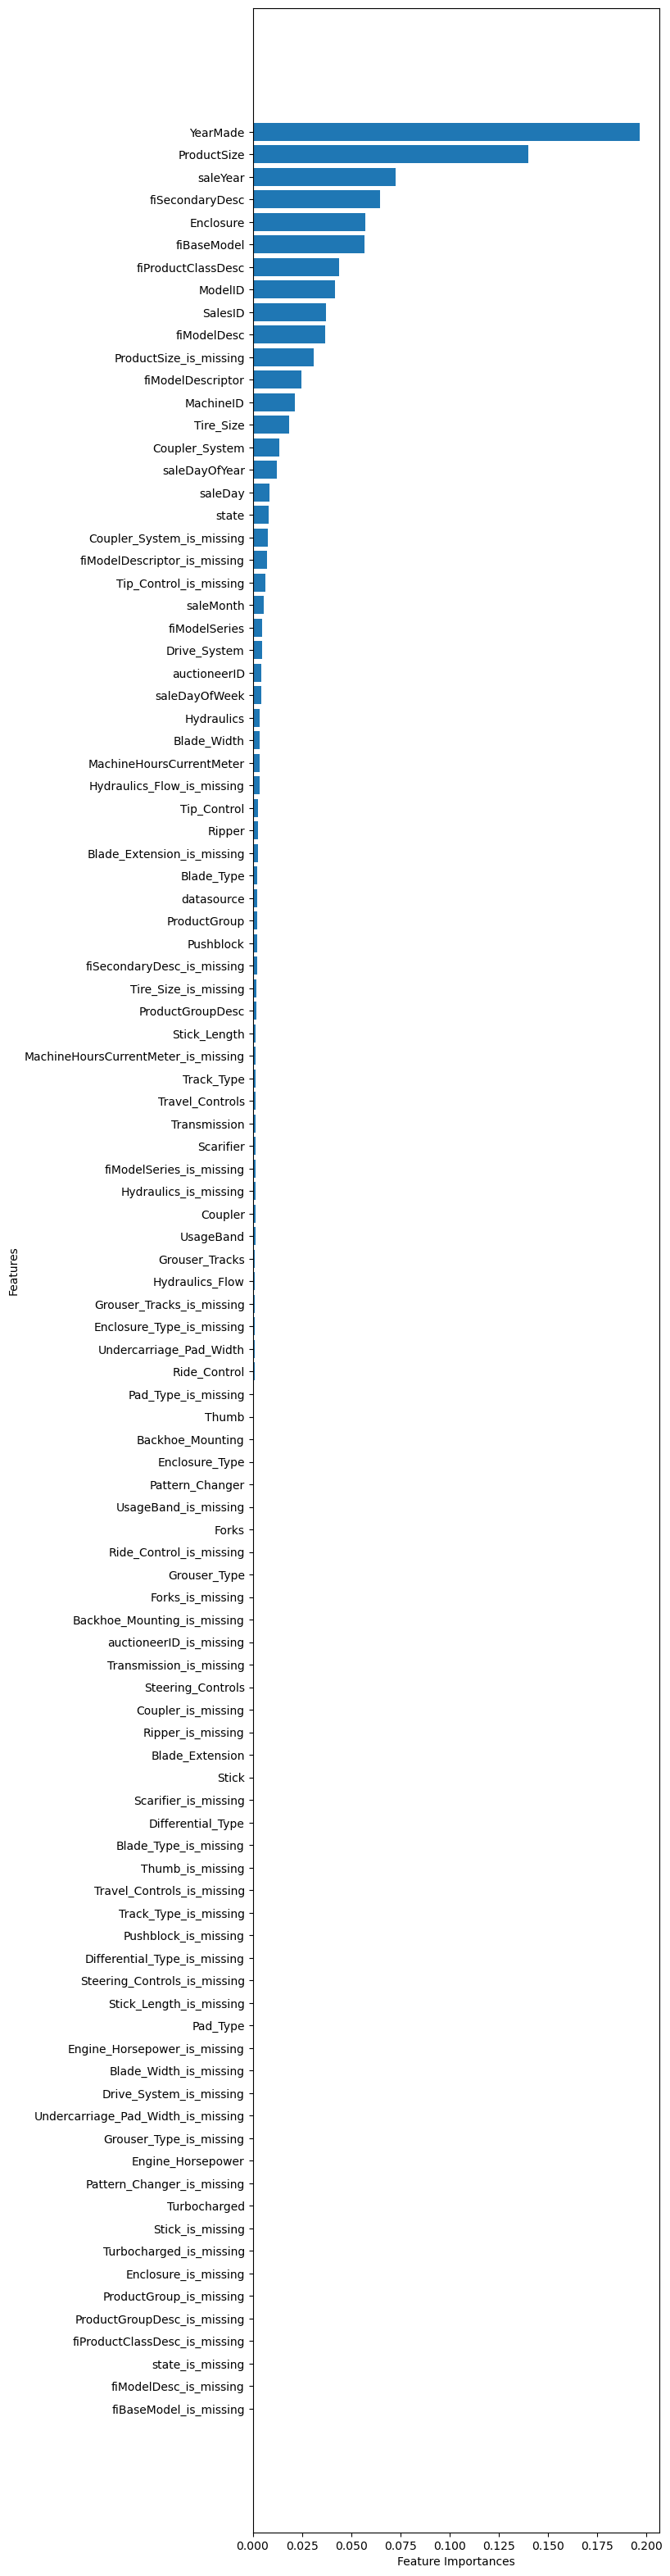

In [166]:
fig,ax=plt.subplots()
fig.set_figheight(40)
ax.barh(df_importances["Features"],df_importances["Importances"])
ax.set_xlabel("Feature Importances")
ax.set_ylabel("Features")

In [194]:
df_importances[df_importances["Features"]=="Ride_Control"].Importances.values[0]

np.float64(0.0008510456588123529)

In [186]:
x_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393098,6260687,1074871,4331,149,2.0,1000,0.0,0,3137,1055,...,True,True,True,True,True,True,True,True,False,False
400217,6312170,1812622,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
400302,6312727,1811599,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
400393,6315051,1858173,17432,149,2.0,2004,0.0,0,3389,1175,...,True,True,True,True,True,True,True,True,True,True


# Experimentation

In [187]:
x_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393098,6260687,1074871,4331,149,2.0,1000,0.0,0,3137,1055,...,True,True,True,True,True,True,True,True,False,False
400217,6312170,1812622,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
400302,6312727,1811599,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
400393,6315051,1858173,17432,149,2.0,2004,0.0,0,3389,1175,...,True,True,True,True,True,True,True,True,True,True


In [189]:
x_train_tmp=x_train.copy()
x_val_tmp=x_val.copy()
x_train.shape,x_train_tmp.shape,x_val.shape,x_val_tmp.shape

((401125, 102), (401125, 102), (11573, 102), (11573, 102))

In [195]:
for col in x_train.columns:
    if df_importances[df_importances["Features"]==col].Importances.values[0] <0.001:
        x_train_tmp.drop(col,axis=1,inplace=True)
        x_val_tmp.drop(col,axis=1,inplace=True)

In [196]:
x_train_tmp.shape,x_val_tmp.shape

((401125, 55), (11573, 55))

In [197]:
%%time
model_tmp=RandomForestRegressor(n_estimators=30,min_samples_split = 3, min_samples_leaf = 2 , max_features=0.5, max_depth= None,n_jobs=-1)
model_tmp.fit(x_train_tmp,y_train)

CPU times: total: 4min 40s
Wall time: 1min 53s


RandomForestRegressor(max_features=0.5, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=30, n_jobs=-1)

In [201]:
def rmsle(y_test,y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

def score_tmp(model):
    y_preds_train=model.predict(x_train_tmp)
    y_preds_val=model.predict(x_val_tmp)
    scores={"MAE Train set":mean_absolute_error(y_train,y_preds_train),
            "MAE valid set":mean_absolute_error(y_val,y_preds_val),
            "RMSLE train set": rmsle(y_train,y_preds_train),
            "RMSLE valid set": rmsle(y_val,y_preds_val),
            "R^2 Score train set":r2_score(y_train,y_preds_train),
            "R^2 Score valid set":r2_score(y_val,y_preds_val)}
    return scores

score_tmp(model_tmp)

{'MAE Train set': 2116.1477524095008,
 'MAE valid set': 5894.657108938919,
 'RMSLE train set': np.float64(0.1105448233187402),
 'RMSLE valid set': np.float64(0.24417800592056718),
 'R^2 Score train set': 0.9767823415285729,
 'R^2 Score valid set': 0.8823143072946651}

In [203]:
score(model)

{'MAE Train set': 2104.966034822308,
 'MAE valid set': 5950.757062742359,
 'RMSLE train set': np.float64(0.11015529133140102),
 'RMSLE valid set': np.float64(0.24515770044025767),
 'R^2 Score train set': 0.9769355158387929,
 'R^2 Score valid set': 0.8808679634021789}

# Saving the model

In [204]:
import pickle

file=open("bulldozer_price_prediction_rf.pkl","wb")
pickle.dump(model_tmp,file)
file.close()

# Loading the model

In [205]:
file=open("bulldozer_price_prediction_rf.pkl","rb")
model_loaded=pickle.load(file)
score_tmp(model_loaded)

{'MAE Train set': 2116.1477524095008,
 'MAE valid set': 5894.657108938919,
 'RMSLE train set': np.float64(0.1105448233187402),
 'RMSLE valid set': np.float64(0.24417800592056718),
 'R^2 Score train set': 0.9767823415285729,
 'R^2 Score valid set': 0.8823143072946651}